# Grid Search for Elastic Net

We'll run a grid-search on the `alpha` and `lambda` parameters of the Elastic Net regression models and pick the model with the lowest log-likelihood. We'll use the tf-idf feature vector representation from the notebook `03_news_groups_tf_idf.ipynb` to build elastic net regression models on.

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [7]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from IPython.display import Image
from wordcloud import WordCloud
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

### 1. Input table

We'll use the input table `YOUR_SCHEMA.bow_tf_idf_vector_training_set` from the notebook `03_news_groups_tf_idf.ipynb`

In [3]:
sql = """
    select
        *
    from
        YOUR_SCHEMA.bow_tf_idf_vector_training_set
    limit 10;
"""
df = psql.read_sql(sql, conn)
conn.commit()
display(df)

,doc_id,feature_vector,label
0,208,"[0.0, 0.0, 1.73019021209, 0.0, 0.0, 0.0, 0.0, ...",0
1,9204,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,1242,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.367...",1
3,14511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,14593,"[0.0, 0.0, 3.02783287115, 0.0, 0.0, 0.0, 0.0, ...",0
5,12817,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
6,4421,"[0.0, 0.0, 0.865095106043, 0.0, 0.0, 0.0, 0.0,...",0
7,13544,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.988...",0
8,210,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.367...",0
9,6730,"[0.0, 0.0, 0.0, 0.0, 0.0, 26.0601587652, 0.0, ...",0


### 2. Perform grid-search on classifier with k-fold cross validation

Elastic Nets combine the the benefits of L1 and L2 regularizations with regression models. L1 regularization results in very sparse features, while L2 regularization results in features whose coefficients are closer to zero. By adjusting the alpha and lambda parameters, we can achieve the benefits of both L1 and L2 regularization. Refer to [MADlib Elastic Net Regression](http://doc.madlib.net/latest/group__grp__elasticnet.html) for more information.

#### UDF for Gridsearch with k-fold cross validation

In [6]:
sql = '''
    drop function if exists YOUR_SCHEMA.elasticnet_gridsearch_cv(
        alphas float8[],  -- list of possible value for alpha
        lambdas float8[], -- list of possible values for lambdas
        input_table text, -- input table
        id_column text, -- name of id column in input table
        features_column text, -- name of features column in input table
        label_column text, -- name of label column in input table
        mdl_table text, -- intermediate table to store elastic net models
        output_table text, -- results of grid search 
        k_folds int -- number of folds
    );

    create or replace function YOUR_SCHEMA.elasticnet_gridsearch_cv(
        alphas float8[],  -- list of possible value for alpha
        lambdas float8[], -- list of possible values for lambdas
        input_table text, -- input table
        id_column text, -- name of id column in input table
        features_column text, -- name of features column in input table
        label_column text, -- name of label column in input table
        mdl_table text, -- intermediate table to store elastic net models
        output_table text, -- results of grid search 
        k_folds int -- number of folds
    )
    returns text
    as
    $$
        import plpy
        from itertools import product

        cv_set = """
            drop table if exists input_table_cv;
            create temp table input_table_cv
            as
            (
                select
                    *,
                    random() as cv_select
                from
                    {input_table}
            );
        """.format(
            input_table = input_table
        )
        plpy.execute(cv_set)

        #training set creation
        training_set = """
            drop table if exists input_table_training_set_cv cascade;
            create temp table input_table_training_set_cv
            as
            (
                select
                    *
                from
                    input_table_cv
                where 
                    cv_select not between {lower_bound} and {upper_bound}
            );
        """

        #test set creation
        test_set = """
            drop table if exists input_table_test_set_cv cascade;
            create temp table input_table_test_set_cv
            as
            (
                select
                    *
                from
                    input_table_cv
                where 
                    cv_select between {lower_bound} and {upper_bound}
            );            
        """

        #model training code
        mdl_train = """
            drop table if exists {mdl_table};
            select 
                madlib.elastic_net_train( 
                    '{training_set}', --tbl_source
                    '{mdl_table}', --tbl_result,
                    '{label_column}', --col_dep_var,
                    '{features_column}', --col_ind_var,
                    'binomial', --regress_family,
                    {alpha}, --alpha (=1 => L1, =0 => L2),
                    {lamda}, --lambda_value,
                    FALSE, --standardize,
                    NULL, --grouping_col,
                    'fista', --optimizer,
                    '', --optimizer_params,
                    NULL, --excluded,
                    10000, --max_iter,
                    1e-6 --tolerance
                );
        """

        mdl_score="""
            drop table if exists input_table_test_set_cv_results cascade;
            create temp table input_table_test_set_cv_results
            as
            (
                select
                    {id_column},
                    {label_column} as actual_label,
                    madlib.elastic_net_binomial_predict(
                        coef_all,
                        intercept,
                        {features_column}
                    ) as predicted_label,            
                    madlib.elastic_net_binomial_prob(
                        coef_all,
                        intercept,
                        {features_column}
                    ) as predicted_label_proba
                from
                    {cv_model} mdl,
                    {test_set} test
            ) distributed randomly;        
        """

        #output table CTAS
        output_table_ctas = """
            drop table if exists {output_table} cascade;
            create table {output_table}
            (
                alpha float8,
                lamda float8,
                fold int,
                auc float8
            )distributed randomly;
        """
        plpy.execute(output_table_ctas.format(output_table=output_table))

        iter = 0
        for alpha, lamda in product(alphas, lambdas):
            plpy.info('Iteration {0} of {1}'.format(iter, len(list(product(alphas, lambdas)))))
            plpy.info('alpha:{0}, lambda:{1}'.format(alpha, lamda))
            for fold in range(k_folds):
                lower_bound = fold*(1.0/k_folds)
                upper_bound = (fold+1)*(1.0/k_folds)

                #create training & test set
                plpy.execute(training_set.format(lower_bound=lower_bound, upper_bound=upper_bound))
                plpy.execute(test_set.format(lower_bound=lower_bound, upper_bound=upper_bound))
                #train model
                plpy.execute(
                    mdl_train.format(
                        alpha=alpha, 
                        lamda=lamda, 
                        training_set='input_table_training_set_cv',
                        mdl_table=mdl_table,
                        label_column=label_column,
                        features_column=features_column
                    )
                )

                #score on test set
                plpy.execute(
                    mdl_score.format(
                        cv_model=mdl_table, 
                        test_set='input_table_test_set_cv',
                        id_column=id_column,
                        label_column=label_column,
                        features_column=features_column
                    )
                )

                #Compute AUC and insert metrics into results table
                auc_sql = """
                    insert into {output_table}
                    select
                        {alpha} as alpha,
                        {lamda} as lambda,         
                        {fold} as fold,
                        pdltools.mf_auc(
                            'input_table_test_set_cv_results',
                            'predicted_label_proba', -- predicted probabilities
                            'actual_label' -- actual column
                        ) as auc
                """.format(
                    alpha=alpha,
                    lamda=lamda,
                    fold=fold,
                    output_table=output_table
                )
                plpy.execute(auc_sql)

            iter+=1
        return 'Grid search results written to {output_table}'.format(output_table=output_table)  
    $$language plpythonu;
'''
psql.execute(sql, conn)
conn.commit()

#### Invoke the grid-search

In [4]:
sql = """
    select
        YOUR_SCHEMA.elasticnet_gridsearch_cv(
            ARRAY[0.05, 0.20,0.70, 0.9], -- alphas
            ARRAY[0.05, 0.20,0.70, 0.9], -- lambdas
            'YOUR_SCHEMA.bow_tf_idf_vector_training_set', -- input table
            'doc_id', -- name of id column in input table
            'feature_vector', -- name of features column in input table
            'label', -- name of label column in input table
            'YOUR_SCHEMA.bow_tf_idf_vector_elasticnet_mdl', -- intermediate table to store elastic net models
            'YOUR_SCHEMA.bow_tf_idf_vector_elasticnet_gridsearchcv_results', -- results of grid search 
            3 -- number of folds
        );
"""
psql.execute(sql, conn)
conn.commit()

### 2. Plot results of grid-search

In [9]:
sql = """
    select
        alpha,
        lamda,
        avg(auc) as avg_auc
    from
        YOUR_SCHEMA.bow_tf_idf_vector_elasticnet_gridsearchcv_results
    group by
        alpha, lamda
    order by 3 desc
"""
df = psql.read_sql(sql, conn)
display(df)
conn.commit()

,alpha,lamda,avg_auc
0,0.05,0.05,0.934419
1,0.20,0.05,0.900376
2,0.05,0.20,0.895014
3,0.70,0.05,0.786730
4,0.05,0.70,0.779066
5,0.20,0.20,0.768162
6,0.05,0.90,0.745529
7,0.90,0.05,0.736417
8,0.20,0.70,0.547853
9,0.20,0.90,0.547853


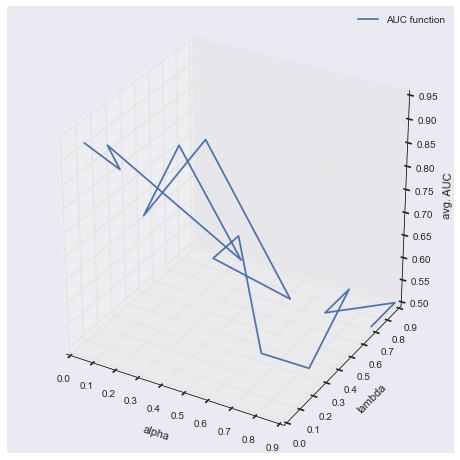

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.gca(projection='3d')
ax.plot(df['alpha'].tolist(), df['lamda'].tolist(), df['avg_auc'].tolist(), label='AUC function')
ax.set_xlabel('alpha')
ax.set_ylabel('lambda')
ax.set_zlabel('avg. AUC')
ax.legend()
plt.show()

Based on the plot and table above, we find the optimal value of alpha and lambda to be 0.05 and 0.05 respectively.

###  4. Retrain model with optimal parameters

In [12]:
sql = '''
drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_elasticnet_mdl;
select 
    madlib.elastic_net_train( 
        'YOUR_SCHEMA.bow_tf_idf_vector_training_set', --tbl_source
        'YOUR_SCHEMA.bow_tf_idf_vector_elasticnet_best_mdl', --tbl_result,
        'label', --col_dep_var,
        'feature_vector', --col_ind_var,
        'binomial', --regress_family,
        0.05, --alpha (=1 => L1, =0 => L2),
        0.05, --lambda_value,
        FALSE, --standardize,
        NULL, --grouping_col,
        'fista', --optimizer,
        '', --optimizer_params,
        NULL, --excluded,
        10000, --max_iter,
        1e-6 --tolerance
    );
'''
psql.execute(sql, conn)
conn.commit()

### 5. Score using trained classifier and display AUC

In [15]:
sql = """
    drop table if exists YOUR_SCHEMA.bow_tf_idf_vector_test_set_prediction_results cascade;
    create table YOUR_SCHEMA.bow_tf_idf_vector_test_set_prediction_results
    as
    (
        select
            doc_id,
            label as actual_label,
            madlib.elastic_net_binomial_predict(
                coef_all,
                intercept,
                feature_vector
            ) as predicted_label,            
            madlib.elastic_net_binomial_prob(
                coef_all,
                intercept,
                feature_vector
            ) as predicted_label_proba
        from
            YOUR_SCHEMA.bow_tf_idf_vector_elasticnet_best_mdl mdl,
            YOUR_SCHEMA.bow_tf_idf_vector_test_set test_set
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

In [16]:
sql = """
    select
        doc_id,
        actual_label,
        predicted_label,
        predicted_label_proba
    from
        YOUR_SCHEMA.bow_tf_idf_vector_test_set_prediction_results
"""
df = psql.read_sql(sql, conn)
df.head()

,doc_id,actual_label,predicted_label,predicted_label_proba
0,2743,0,False,0.172692
1,15955,0,False,0.249295
2,17730,0,False,0.213157
3,1465,1,False,0.280180
4,5438,0,False,0.264577


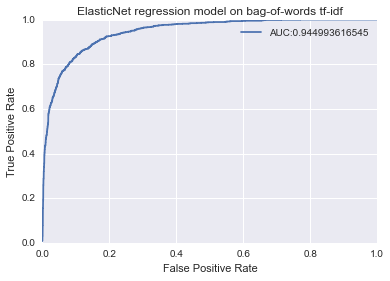

In [18]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
fpr, tpr, thresholds = metrics.roc_curve(
                            df['actual_label'].tolist(),
                            df['predicted_label_proba'].tolist(), 
                            pos_label=1
                        )
auc = metrics.auc(fpr, tpr)
rocdf = pd.DataFrame(np.transpose([fpr, tpr, thresholds]), columns = ['fpr','tpr','thresholds'])
rocdf.plot(x='fpr',y='tpr', label='AUC:{0}'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ElasticNet regression model on bag-of-words tf-idf')
plt.show()